In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [3]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_1lead = import_afc_data()

data_1lead = [x for x in data_1lead if x[1] != '~']

labelmap = {x:i for i,x in enumerate(list(set([x[1] for x in data_1lead])))}

dataset_1lead = WindowDataset(data_1lead, labelmap, device=device)

  0%|          | 0/8528 [00:00<?, ?it/s]

100%|██████████| 8528/8528 [00:30<00:00, 284.20it/s]
8249it [00:22, 372.17it/s]


In [6]:
data_12lead = import_balanced_12lead_data()

dataset_12lead = WindowDataset(data_12lead, labelmap, device=device, trim_samples=1000)

3318it [00:03, 884.33it/s]


In [7]:
pd.Series([x[1] for x in data_1lead]).value_counts()

N    5076
O    2415
A     758
Name: count, dtype: int64

In [8]:
pd.Series([x[1] for x in data_12lead]).value_counts()

O    1106
A    1106
N    1106
Name: count, dtype: int64

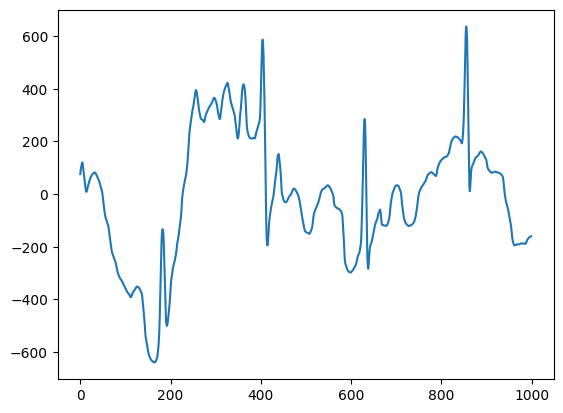

In [9]:
def plotwave(x, n=1000):
    plt.plot(x[:n])

plotwave(data_1lead[19][0])

In [10]:
value_counts = dataset_1lead.get_value_counts(count=3)
weights = [sum(value_counts)/x for x in value_counts]
# weights[labelmap['~']] = weights[labelmap['N']]

In [11]:
value_counts

[2415, 758, 5076]

# Training

## Single-Lead Model

In [12]:
# Train k-fold crossvalidated model on 1 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.lr = 0.002
trainparams.n_epochs = 200

# history, confusion_list = train_kfold_model(dataset_1lead, trainparams, test=True)

# plot_tt_graph(history, idx=0)
# display_results(history,trainparams=trainparams)

In [13]:
def plt_c(cm):
    labelmap2 = {x:y for y,x in labelmap.items()}

    # Converting the confusion matrix to fraction
    cm_fraction = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm_fraction)

    # Creating a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_fraction, annot=True, fmt=".2f", cmap='Blues', xticklabels=[labelmap2[i] for i in range(4)], yticklabels=[labelmap2[i] for i in range(4)])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix (as fraction)')
    plt.show()

In [17]:
## Build model on entire 1lead dataset and save to buffer

buffer = io.BytesIO()

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs = 200

model, history = train_entire_model(dataset_1lead, trainparams)

torch.save(model.state_dict(), buffer)

Epoch:10/200 AVG Training Loss:2.70588 AVG Test Loss:2.58605 AVG Training F1 47.06 % AVG Test F1 47.94 %
Epoch:20/200 AVG Training Loss:2.46107 AVG Test Loss:2.34667 AVG Training F1 56.81 % AVG Test F1 55.15 %
Epoch:30/200 AVG Training Loss:2.33971 AVG Test Loss:2.29230 AVG Training F1 58.35 % AVG Test F1 55.96 %
Epoch:40/200 AVG Training Loss:2.29998 AVG Test Loss:2.24394 AVG Training F1 58.25 % AVG Test F1 59.45 %
Epoch:50/200 AVG Training Loss:2.29700 AVG Test Loss:2.16656 AVG Training F1 59.35 % AVG Test F1 59.63 %
Epoch:60/200 AVG Training Loss:2.25582 AVG Test Loss:2.13735 AVG Training F1 60.84 % AVG Test F1 61.65 %
Epoch:70/200 AVG Training Loss:2.16226 AVG Test Loss:2.15303 AVG Training F1 62.78 % AVG Test F1 60.06 %
Epoch:80/200 AVG Training Loss:2.14989 AVG Test Loss:2.09136 AVG Training F1 62.82 % AVG Test F1 63.55 %
Epoch:90/200 AVG Training Loss:2.17525 AVG Test Loss:2.09472 AVG Training F1 63.15 % AVG Test F1 65.29 %
Epoch:100/200 AVG Training Loss:2.12643 AVG Test Loss:2

## Transfer

Fold 1
Epoch:10/100 AVG Training Loss:1.09869 AVG Test Loss:1.09715 AVG Training F1 32.32 % AVG Test F1 16.67 %
Epoch:20/100 AVG Training Loss:1.08723 AVG Test Loss:1.08896 AVG Training F1 41.02 % AVG Test F1 44.13 %
Epoch:30/100 AVG Training Loss:1.00161 AVG Test Loss:0.99705 AVG Training F1 56.06 % AVG Test F1 62.20 %
Epoch:40/100 AVG Training Loss:0.67536 AVG Test Loss:0.76017 AVG Training F1 75.39 % AVG Test F1 64.16 %
Epoch:50/100 AVG Training Loss:0.50547 AVG Test Loss:0.67799 AVG Training F1 79.58 % AVG Test F1 68.82 %
Epoch:60/100 AVG Training Loss:0.40443 AVG Test Loss:0.66349 AVG Training F1 84.47 % AVG Test F1 70.81 %
Epoch:70/100 AVG Training Loss:0.38049 AVG Test Loss:0.68130 AVG Training F1 85.12 % AVG Test F1 69.81 %
Epoch:80/100 AVG Training Loss:0.30284 AVG Test Loss:0.69471 AVG Training F1 90.31 % AVG Test F1 70.93 %
Epoch:90/100 AVG Training Loss:0.22719 AVG Test Loss:0.76453 AVG Training F1 91.48 % AVG Test F1 70.24 %
Early stopping triggered after epoch 93


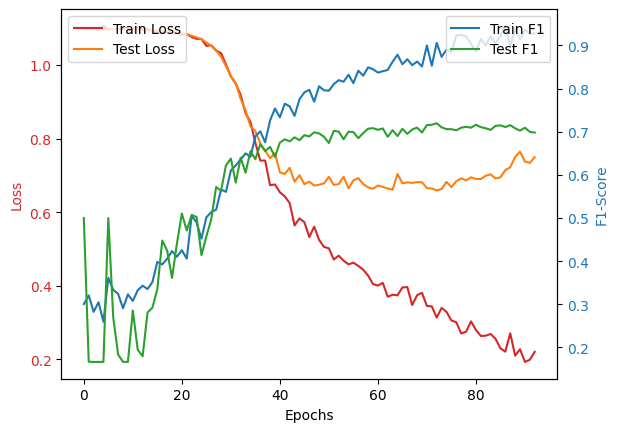

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.2200694183508555, average F1 score 94.50469484618283
Test: Average loss 0.7494209110736847, average F1 score 71.94960118966577


In [ ]:
## Control training - no transfer
## k-fold with leave-(k-1)-out

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, test=True)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:0.69102 AVG Test Loss:0.61129 AVG Training F1 69.22 % AVG Test F1 78.85 %
Epoch:20/100 AVG Training Loss:0.49678 AVG Test Loss:0.42501 AVG Training F1 78.76 % AVG Test F1 82.95 %
Epoch:30/100 AVG Training Loss:0.44077 AVG Test Loss:0.43532 AVG Training F1 82.09 % AVG Test F1 83.53 %
Epoch:40/100 AVG Training Loss:0.39360 AVG Test Loss:0.36439 AVG Training F1 84.04 % AVG Test F1 84.42 %
Epoch:50/100 AVG Training Loss:0.38340 AVG Test Loss:0.37143 AVG Training F1 83.75 % AVG Test F1 84.83 %
Epoch:60/100 AVG Training Loss:0.34448 AVG Test Loss:0.39858 AVG Training F1 85.50 % AVG Test F1 85.22 %
Early stopping triggered after epoch 66


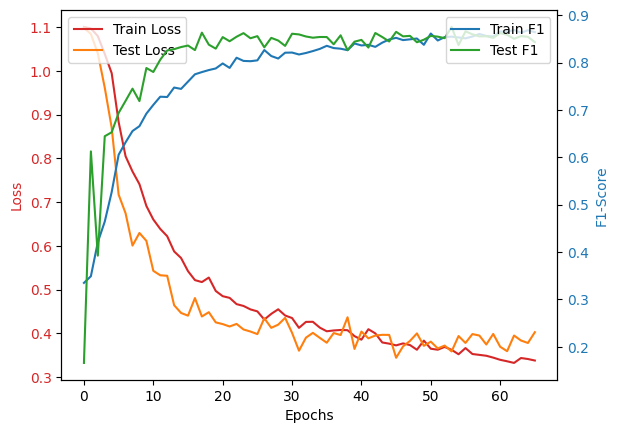

Overall results of 10 fold cross-validation with leave-1-out
Train: Average loss 0.33786726494630176, average F1 score 86.87815109193521
Test: Average loss 0.402590811252594, average F1 score 87.53095279371638


In [ ]:
## Control training - no transfer
## k-fold with leave-1-out

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=1
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, test=True)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:0.60755 AVG Test Loss:0.54415 AVG Training F1 79.26 % AVG Test F1 74.30 %
Epoch:20/100 AVG Training Loss:0.46822 AVG Test Loss:0.51017 AVG Training F1 85.46 % AVG Test F1 77.77 %
Early stopping triggered after epoch 28


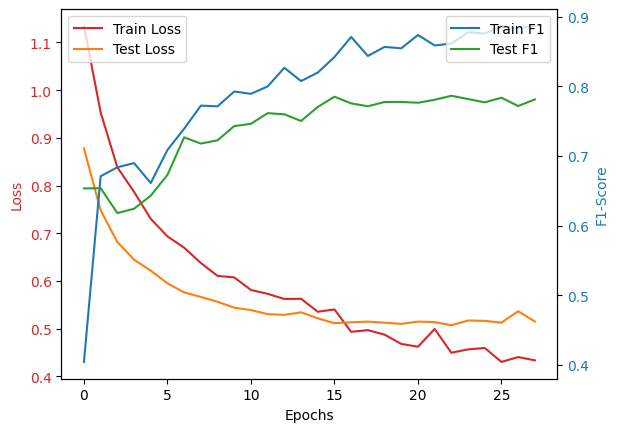

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.43381503224372864, average F1 score 88.67770550920393
Test: Average loss 0.5151991633077463, average F1 score 78.65113749234787


In [ ]:
## Train 10-fold crossvalidated model transferred, 1 -> 12 lead data
## No inter-channel connections, pure vote model

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=5

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, buffer=buffer, test=True)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:1.24057 AVG Test Loss:0.62867 AVG Training F1 69.20 % AVG Test F1 65.31 %
Epoch:20/100 AVG Training Loss:1.14588 AVG Test Loss:0.54930 AVG Training F1 81.64 % AVG Test F1 74.39 %
Epoch:30/100 AVG Training Loss:1.10169 AVG Test Loss:0.51794 AVG Training F1 85.86 % AVG Test F1 77.22 %
Epoch:40/100 AVG Training Loss:1.08453 AVG Test Loss:0.53494 AVG Training F1 87.89 % AVG Test F1 76.38 %
Epoch:50/100 AVG Training Loss:1.05733 AVG Test Loss:0.54537 AVG Training F1 89.88 % AVG Test F1 76.05 %
Early stopping triggered after epoch 56


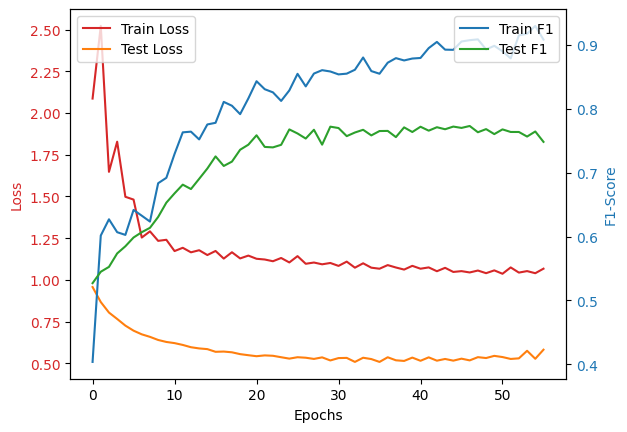

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 1.067525029182434, average F1 score 93.00366522363831
Test: Average loss 0.5822574011981487, average F1 score 77.3241874125477


In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data
## Transfer adds new fc layer as well as allowing intermediate connections between LSTM1 and LSTM2

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferAdaptersLSTMModel, buffer=buffer, test=True)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/200 AVG Training Loss:0.93111 AVG Test Loss:0.76012 AVG Training F1 66.57 % AVG Test F1 69.59 %
Epoch:20/200 AVG Training Loss:0.73378 AVG Test Loss:0.65622 AVG Training F1 78.23 % AVG Test F1 69.73 %
Epoch:30/200 AVG Training Loss:0.59586 AVG Test Loss:0.61479 AVG Training F1 84.36 % AVG Test F1 72.78 %
Epoch:40/200 AVG Training Loss:0.51937 AVG Test Loss:0.64727 AVG Training F1 87.97 % AVG Test F1 73.05 %
Early stopping triggered after epoch 50


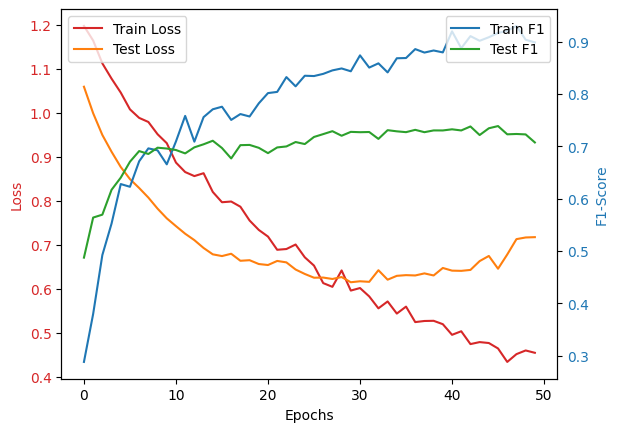

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.45429550607999164, average F1 score 93.02565775168516
Test: Average loss 0.7173491989572843, average F1 score 73.88623549503822


In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data
## Transfer adds new fc layer and new LSTM layer

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs=200
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=True)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

In [ ]:
# ## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

# trainparams = TrainParams()
# trainparams.weights = weights
# trainparams.labelmap = labelmap
# trainparams.k=10
# trainparams.m=9
# trainparams.early_stopping=20


# for base_decay in [0.00001 * 2 ** i for i in range(10)]:
#     trainparams.base_decay = base_decay

#     history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False, verbose=False)

#     # plot_tt_graph(history, idx=0)

#     print(f'\n\n\n##### decay rate {base_decay}')
#     display_results(history, trainparams=trainparams)

### Varying Dataset Size

In [ ]:
models = [
    TransferFCModel,
    TransferAdaptersLSTMModel,
    Transfer1LSTMModel
]

km_list = [
    (10, 1),
    (10, 2),
    (10, 3),
    (10, 4),
    (10, 5),
    (10, 6),
    (10, 7),
    (10, 8),
    (7, 6),
    (10, 9),
    (15, 14),
    (20, 19),
    (30, 29),
    (40, 39),
    (50, 49)
]

test = False

hist = {}

for model in models:
    hist[model] = [{},{}]
    print(f'model {model.__name__}')

    for random_init in [True, False]:
        for k,m in km_list:
            trainparams = TrainParams()
            trainparams.weights = weights
            trainparams.labelmap = labelmap
            trainparams.n_epochs=200
            trainparams.k=k
            trainparams.m=m
            trainparams.early_stopping=5

            if random_init:
                history = train_kfold_transfer_model(dataset_12lead, trainparams, model, test=test, verbose=False)
            else:
                history = train_kfold_transfer_model(dataset_12lead, trainparams, model, buffer=buffer, test=test, verbose=False)

            hist[model][int(random_init)][(k,m)] = history

model TransferFCModel
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [6.6979e-02, 1.2463e+00, 1.2463e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [2.1512e+00, 2.6872e+00, 2.6872e+00,  ..., 5.3687e-01,
          5.3910e-01, 5.3910e-01],
         [2.7271e-02, 5.8071e-02, 7.2272e-01,  ..., 1.6804e-01,
          3.0831e-01, 3.9163e-01],
         [7.8387e-01, 6.0697e-01, 1.2297e+00,  ..., 3.7959e-01,
          1.3853e-01, 1.4358e-01]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.5372e-01,
          2.5372e-01, 2.3969e-01],
         [3.2548e-02, 8.5957e-03, 0.0000e+00,  ..., 4.0058e-01,
          4.0058e-01, 4.0058e-01],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.0092e-01,
          5.0092e-01, 2.0334e-01],
         ...,
         [6.3028e-01, 4.8400e-01, 3.0534e-01,  ..., 1.119

KeyboardInterrupt: 

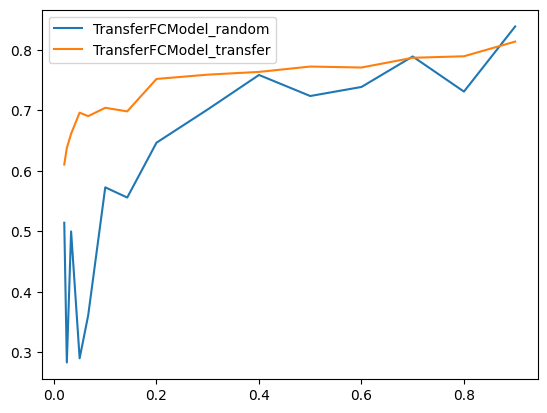

In [ ]:
def display_history_varying_trainsize(hist):
    legend = []

    for model in hist.keys():
        for random_init in [True, False]:
            values = []

            for k,m in hist[model][int(random_init)].keys():
                perc_train = (k-m)/k
                
                this_hist = hist[model][int(random_init)][(k,m)]
                # print([max(x) for x in this_hist['test_F']])
                values.append((perc_train, np.mean([max(x) for x in this_hist['test_F']])))

            x,y = zip(*values)
            plt.plot(list(x), list(y))

            # plt.plot(values)
                
            if random_init:
                legend.append(f'{model.__name__}_random')
            else:
                legend.append(f'{model.__name__}_transfer')

    plt.legend(legend)

    plt.show()


display_history_varying_trainsize(hist)

## Augmented Data

In [18]:
control_dataset = WindowDataset(data_12lead, labelmap, device=device, trim_samples=1000)

3318it [00:03, 832.58it/s]


In [19]:
### Allowing interaction terms between first and second LSTM layer by adding 'adapters'
class TransferAdaptersCNNModel(TransferModel):
    def __init__(self, base=None, allow_finetune=True, output_size=3):
        super().__init__(base, allow_finetune, output_size)

        self.intermediate_fc = nn.Linear(12*16, 12*16)

        init.constant_(self.intermediate_fc.weight, 0)
        init.constant_(self.intermediate_fc.bias, 0)        

        identity_matrix = torch.eye(12*16)
        self.intermediate_fc.weight.data.copy_(identity_matrix)

        self.fc_layer = nn.Linear(2 * 12 * self.lstm_hidden_size, output_size)
        self.fc_dropout = nn.Dropout(0.5)

    def forward(self, x):
        outputs = super().forward(x, end=2)
        
        x = torch.stack(outputs, dim=3)




        x_flattened = x.reshape(x.size(0), -1, x.size(2))
        x_flattened = x_flattened.transpose(1,2)
        x_transformed = self.intermediate_fc(x_flattened)
        # x_transformed = x_flattened
        # x_transformed = F.relu(x_transformed)
        
        x_transformed = x_transformed.transpose(1,2)
        x = x_transformed.reshape((x_transformed.shape[0], 16, x_transformed.shape[2], 12)).contiguous()
        
        x = super().forward(x,start=2, end=6)

        x = torch.cat(x, dim=1)
        
        x = self.fc_dropout(x)
        x = self.fc_layer(x)

        return x
    
    def get_l1_weightdiff(self, weight_factor=10):
        cost = super().get_l1_weightdiff()

        cost += weight_factor * (self.intermediate_fc.weight - torch.eye(12*16, device=next(self.base_model.parameters()).device)).abs().sum()
        cost += weight_factor * (self.intermediate_fc.bias - torch.zeros(12*16, device=next(self.base_model.parameters()).device)).abs().sum()

        return cost

In [20]:
# test_data = torch.randn([10, 200, 1], dtype=torch.float32, device=device)
# model_t = TransferAdaptersCNNModel(base=buffer).to(device)
# model_t.forward(test_data)
# print()

In [21]:
def test_forwards(model_1,model_2,dataset,labelmap,device,batch_size=128,max_norm=1):
    # print(model_1)
    device = next(model_1.parameters()).device

    dataloader = DataLoader(dataset, batch_size=batch_size)

    model_1.eval()
    model_2.eval()
    for i,batch in enumerate(dataloader, 0):
        x, label = batch

        y = model_1.forward(x)
        print(y[0,:])

        print('BREAKKKK')

        y = model_2.forward(x)
        print(y[0,:])

        break

In [22]:
model_c = TransferFCModel(base=buffer).to(device)
model_t = TransferAdaptersCNNModel(base=buffer).to(device)
model_t.fc_layer = model_c.fc_layer

test_forwards(model_c, model_t, control_dataset, labelmap, device)

tensor([-0.0658,  0.4387,  0.1655], device='cuda:0', grad_fn=<SliceBackward0>)
BREAKKKK
tensor([-0.0658,  0.4387,  0.1655], device='cuda:0', grad_fn=<SliceBackward0>)


In [23]:
test_forwards(model_t, control_dataset, labelmap, device)

TypeError: test_forwards() missing 1 required positional argument: 'device'

In [24]:
def test_forwards(model,dataset,labelmap,device,batch_size=128,max_norm=1):
    device = next(model.parameters()).device

    dataloader = DataLoader(dataset, batch_size=batch_size)

    model.train()
    for i,batch in enumerate(dataloader, 0):
        x, label = batch

        x = model.forward(x)
        print(len(x))
        print(x.shape)

        break

test_forwards(TransferAdaptersCNNModel(base=buffer).to(device), control_dataset, labelmap, device)

128
torch.Size([128, 3])


In [25]:

class PerlinAugment():
    def __init__(self, device, sources=2, channel_count=12):
        self.device = device

        if random.uniform(0,1) > 1.0: # I don't think doing flipx is correct at the moment.
            self.flipx = True
        else:
            self.flipx = False
        if random.uniform(0,1) > 1.0:
            self.flipy = True
        else:
            self.flipy = False

        self.perlin_values = []
        for i in range(channel_count):
            arr = []
            for j in range(sources):
                arr.append(random.uniform(-1,1))
            self.perlin_values.append(arr)

        # self.perlin_values[0] = [1,0]
        # self.perlin_values[1] = [0,1]

        self.channel_count = channel_count

    def __call__(self, waveform):
        shape = (len(self.perlin_values[0]),1000,100)

        g_cuda = torch.Generator(device='cuda')
        g_cuda.seed()

        perlin = FractalPerlin2D(shape, [(20,20)], [20], generator=g_cuda)()

        # perlin_noise = []
        # for i in range(len(self.perlin_values[0])):
        #     # noise = PerlinNoise(octaves=1)
        #     # perlin_noise.append([noise(i/50) for i in range(1000)])
        #     perlin_noise.append([0 for i in range(1000)])

        # perlin_noise = torch.tensor(perlin_noise, device=self.device).transpose(0,1)

        perlin_noise = perlin[:,:,50].transpose(0,1)

        # plt.plot(perlin_noise[:,0].cpu().numpy())
        # plt.plot(perlin_noise[:,1].cpu().numpy())

        waveform = waveform.clone()

        # waveform[:,0:2] = 0

        for i,valueset in enumerate(self.perlin_values):
            

            for j,value in enumerate(valueset):
                waveform[:,i] += perlin_noise[:,j] * value

        return waveform


class AugmentDataset(WindowDataset):
    def __init__(self, data, labelmap, threshold_length=1000, device='cpu', eval=False, trim=None, trim_samples=None):
        # assert len(data[0][0].shape) == 1 ## We don't want 2d data here!
        
        super().__init__(data, labelmap, threshold_length=threshold_length, device=device, eval=eval, trim=trim, trim_samples=trim_samples)

        self.augment = PerlinAugment(device)

    def __getitem__(self, idx):
        waveform, label = super().__getitem__(idx)
        
        return self.augment(waveform), label
    
    def get_value_counts(self, count=3):
        counts = [0] * count

        for _,label in self.data:
            counts[label.item()] += 1

        return counts

In [26]:
augment_dataset = AugmentDataset(data_12lead, labelmap, device=device, trim_samples=1000)

3318it [00:04, 828.72it/s]


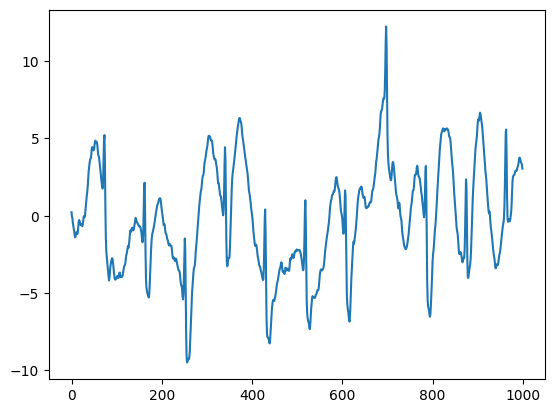

In [27]:
waveform, label = augment_dataset.__getitem__(0)
plt.plot(waveform[:,4].cpu())

Fold 1
Epoch:10/100 AVG Training Loss:0.64414 AVG Test Loss:0.62156 AVG Training F1 74.76 % AVG Test F1 68.90 %
Epoch:20/100 AVG Training Loss:0.57146 AVG Test Loss:0.62669 AVG Training F1 80.04 % AVG Test F1 71.66 %
Early stopping triggered after epoch 26
Fold 2
Epoch:10/100 AVG Training Loss:0.63949 AVG Test Loss:0.63737 AVG Training F1 73.03 % AVG Test F1 66.54 %
Epoch:20/100 AVG Training Loss:0.56329 AVG Test Loss:0.63063 AVG Training F1 79.20 % AVG Test F1 68.47 %
Early stopping triggered after epoch 24
Fold 3
Epoch:10/100 AVG Training Loss:0.64488 AVG Test Loss:0.62954 AVG Training F1 70.97 % AVG Test F1 68.43 %
Epoch:20/100 AVG Training Loss:0.55922 AVG Test Loss:0.64474 AVG Training F1 80.83 % AVG Test F1 70.32 %
Early stopping triggered after epoch 21
Fold 4
Epoch:10/100 AVG Training Loss:0.61751 AVG Test Loss:0.60740 AVG Training F1 77.04 % AVG Test F1 69.00 %
Epoch:20/100 AVG Training Loss:0.57013 AVG Test Loss:0.60472 AVG Training F1 79.74 % AVG Test F1 70.97 %
Early stoppi

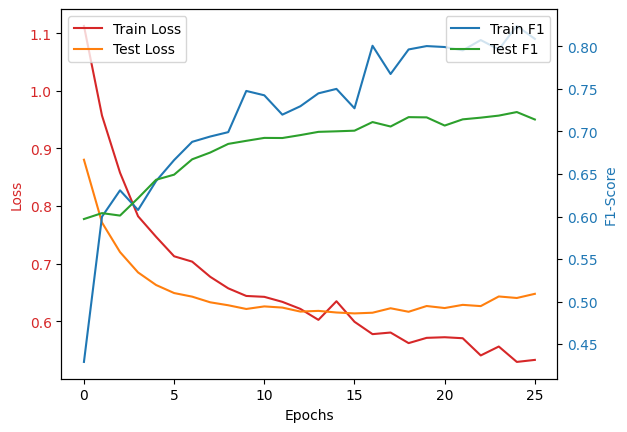

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.5469333022832871, average F1 score 82.37029112429666
Test: Average loss 0.6268632423132658, average F1 score 70.95195505315964


In [28]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

# augment_dataset = AugmentDataset(data_12lead, labelmap, device=device, trim_samples=1000)

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=10

history = train_kfold_transfer_model(augment_dataset, trainparams, TransferFCModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:0.69351 AVG Test Loss:0.62845 AVG Training F1 67.61 % AVG Test F1 68.10 %
Epoch:20/100 AVG Training Loss:0.59682 AVG Test Loss:0.62819 AVG Training F1 78.68 % AVG Test F1 70.72 %
Epoch:30/100 AVG Training Loss:0.54100 AVG Test Loss:0.65190 AVG Training F1 82.42 % AVG Test F1 71.74 %
Early stopping triggered after epoch 31
Fold 2
Epoch:10/100 AVG Training Loss:0.65876 AVG Test Loss:0.61616 AVG Training F1 74.75 % AVG Test F1 69.04 %
Epoch:20/100 AVG Training Loss:0.56562 AVG Test Loss:0.62369 AVG Training F1 82.99 % AVG Test F1 71.52 %
Early stopping triggered after epoch 28
Fold 3
Epoch:10/100 AVG Training Loss:0.69786 AVG Test Loss:0.63371 AVG Training F1 71.00 % AVG Test F1 68.44 %
Epoch:20/100 AVG Training Loss:0.58068 AVG Test Loss:0.66242 AVG Training F1 79.16 % AVG Test F1 68.53 %
Early stopping triggered after epoch 25
Fold 4
Epoch:10/100 AVG Training Loss:0.69826 AVG Test Loss:0.61130 AVG Training F1 73.71 % AVG Test F1 69.83 %
Epoch:20/100

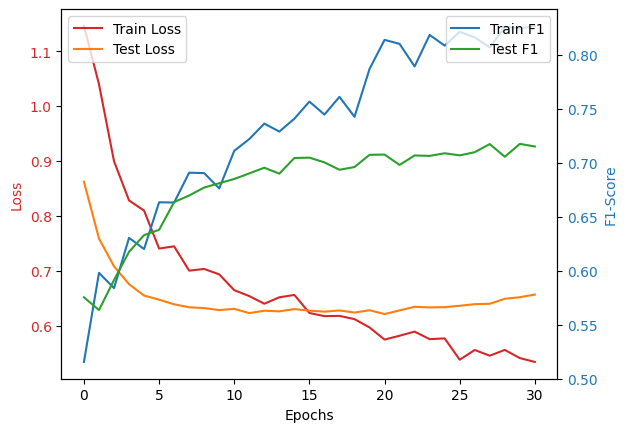

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.5670437584320703, average F1 score 83.6137106098672
Test: Average loss 0.6292031983534495, average F1 score 71.4467828603717


In [29]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

# augment_dataset = AugmentDataset(data_12lead, labelmap, device=device, trim_samples=1000)

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=10

# control_dataset = WindowDataset(data_12lead[1000:1300], labelmap, device=device, trim_samples=1000)

history = train_kfold_transfer_model(augment_dataset, trainparams, TransferAdaptersCNNModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:1.15965 AVG Test Loss:0.63911 AVG Training F1 67.22 % AVG Test F1 67.18 %
Epoch:20/100 AVG Training Loss:1.05177 AVG Test Loss:0.60643 AVG Training F1 78.17 % AVG Test F1 72.85 %
Epoch:30/100 AVG Training Loss:1.02290 AVG Test Loss:0.62792 AVG Training F1 82.70 % AVG Test F1 72.19 %
Early stopping triggered after epoch 33
Fold 2
Epoch:10/100 AVG Training Loss:1.14162 AVG Test Loss:0.65890 AVG Training F1 69.63 % AVG Test F1 66.18 %
Epoch:20/100 AVG Training Loss:1.01750 AVG Test Loss:0.63269 AVG Training F1 75.12 % AVG Test F1 67.35 %
Epoch:30/100 AVG Training Loss:0.99457 AVG Test Loss:0.62343 AVG Training F1 83.50 % AVG Test F1 69.63 %
Early stopping triggered after epoch 37
Fold 3
Epoch:10/100 AVG Training Loss:1.16220 AVG Test Loss:0.64571 AVG Training F1 66.42 % AVG Test F1 67.20 %
Epoch:20/100 AVG Training Loss:1.04108 AVG Test Loss:0.61289 AVG Training F1 75.78 % AVG Test F1 70.19 %
Epoch:30/100 AVG Training Loss:0.99962 AVG Test Loss:0.6165

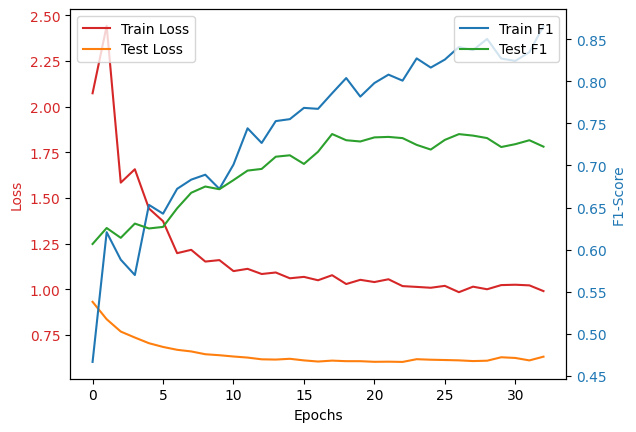

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 1.0080268541971842, average F1 score 85.7565159428441
Test: Average loss 0.6204151092718044, average F1 score 73.67917537030897


In [30]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

# augment_dataset = AugmentDataset(data_12lead, labelmap, device=device, trim_samples=1000)

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=10

# control_dataset = WindowDataset(data_12lead[1000:1300], labelmap, device=device, trim_samples=1000)

history = train_kfold_transfer_model(augment_dataset, trainparams, TransferAdaptersLSTMModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)